In [1]:
using Pkg
Pkg.activate(mktempdir())
Pkg.update()
Pkg.add([
    "Flux",
    "LinearAlgebra",
    "Statistics",
    "Plots",
    "Optimisers"
])

  Activating new project at `C:\Users\79021\AppData\Local\Temp\jl_SZHcdw`
    Updating registry at `C:\Users\79021\.julia\registries\General.toml`
     Project No packages added to or removed from `C:\Users\79021\AppData\Local\Temp\jl_SZHcdw\Project.toml`
    Manifest No packages added to or removed from `C:\Users\79021\AppData\Local\Temp\jl_SZHcdw\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\79021\AppData\Local\Temp\jl_SZHcdw\Project.toml`
  [587475ba] + Flux v0.16.7
  [3bd65402] + Optimisers v0.4.7
  [91a5bcdd] + Plots v1.41.4
  [10745b16] + Statistics v1.11.1
  [37e2e46d] + LinearAlgebra v1.12.0
    Updating `C:\Users\79021\AppData\Local\Temp\jl_SZHcdw\Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [7d9f7c33] + Accessors v0.1.43
  [79e6a3ab] + Adapt v4.4.0
  [66dad0bd] + AliasTables v1.1.3
  [dce04be8] + ArgCheck v2.5.0
  [a9b6321e] + Atomix v1.1.2
  [198e06fe] + BangBang v0.4.6
  [9718e550] + Baselet v0.1.1
  [d1d4a3ce] + BitFlags v0.1.9
  [082447d4] 


mHC: Complete Demonstration
DEMO: Sinkhorn-Knopp Projection

Random matrix:


After Sinkhorn-Knopp (doubly stochastic):

Verification:
Row sums: Float32[1.0, 1.0, 1.0, 1.0]
Col sums: Float32[1.0, 1.0, 1.0, 1.0]
All non-negative: true
Doubly stochastic: true
DEMO: Propagation Stability Comparison

--- Unconstrained (HC-style) ---
Single layer: forward=4.46, backward=4.57
30-layer composite: forward=7.013895e6, backward=9.567694e6

--- Doubly Stochastic (mHC-style) ---
Single layer: forward=1.0, backward=1.0
30-layer composite: forward=1.0, backward=1.0
TRAINING COMPARISON: Residual vs HC vs mHC
Layers: 8, Hidden: 64, Expansion: 4
Data: (32, 3000)

Creating models...
ResidualMLP: 268618 params
HCMLP: 324514 params
mHCMLP: 324514 params

Training...
Epoch 1:
  Res - Loss: 0.1699, Acc: 100.0%
  HC  - Loss: 0.2588, Acc: 100.0%, Gain: 1.19
  mHC - Loss: 0.1016, Acc: 100.0%, Gain: 1.0
Epoch 5:
  Res - Loss: 0.0007, Acc: 100.0%
  HC  - Loss: 0.0004, Acc: 100.0%, Gain: 1.19
  mHC - Loss: 0.000

4×4 Matrix{Float32}:
 -1.14  0.42  -2.2   -0.66
 -0.61  0.69   0.59  -3.16
  0.91  0.92  -1.49   0.78
 -0.22  0.87   0.69   0.87

4×4 Matrix{Float32}:
 0.223  0.406  0.071  0.3
 0.18   0.253  0.555  0.012
 0.453  0.177  0.038  0.332
 0.144  0.164  0.335  0.357

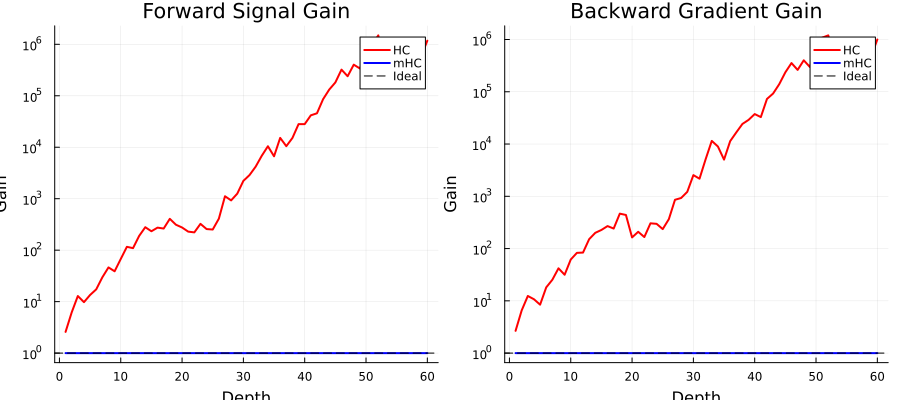

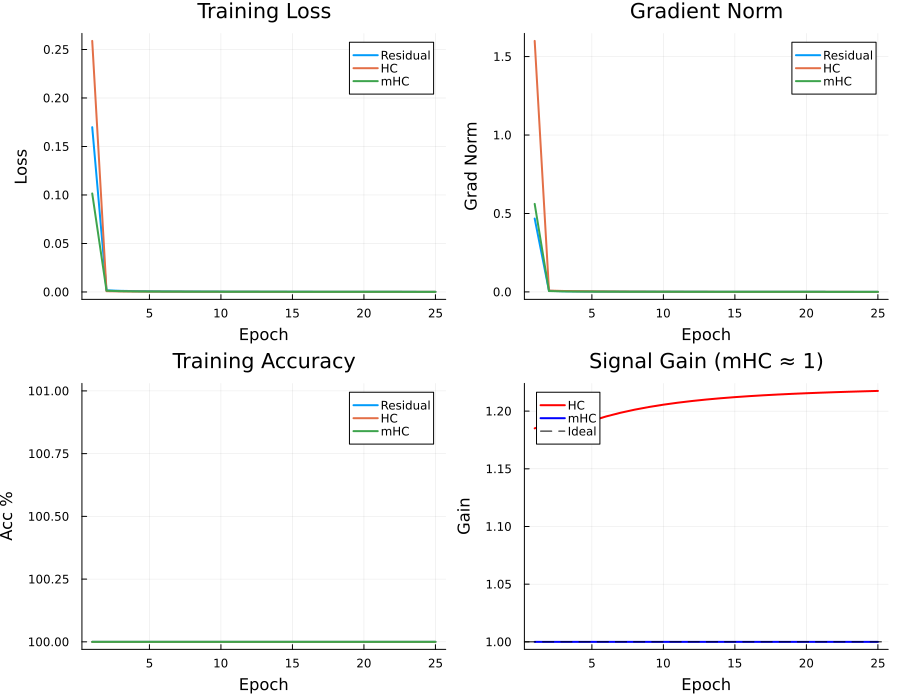

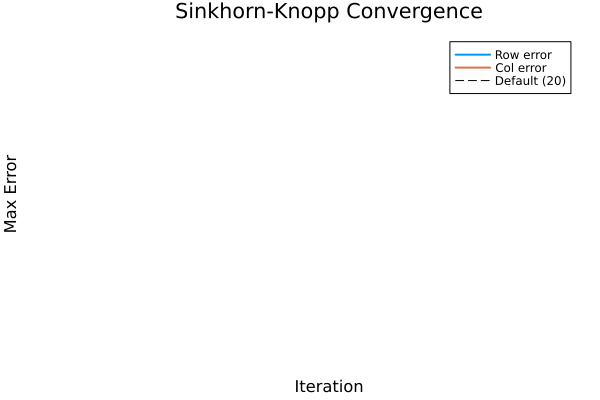

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\79021\.julia\packages\PlotUtils\HX80C\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\79021\.julia\packages\PlotUtils\HX80C\src\ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 12 for log10 based yscale
└ @ Plots C:\Users\79021\.julia\packages\Plots\xC48f\src\utils.jl:105
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\79021\.julia\packages\PlotUtils\HX80C\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\79021\.julia\packages\PlotUtils\HX80C\src\ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 12 for log10 based yscale
└ @ Plots C:\Users\79021\.julia\packages\Plots\xC48f\src\utils.jl:105
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\79021\.julia\packages\PlotUtils\HX80C\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\79021\.julia\packages\PlotUtils\HX80C\src\ticks.jl:194
┌ Warn

(models = (residual = ResidualMLP(Dense(32 => 64), ResidualBlock[ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64))), ResidualBlock(Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64)))], Dense(64 => 10), LayerNorm(64)), hc = HCMLP(4, Dense(32 => 256), HyperConnectionLayer[HyperConnectionLayer(4, 64, Chain(LayerNorm(64), Dense(64 => 256, relu), Dense(256 => 64)), Dense(256 => 4), Dense(256 => 4), Dense(256 => 16), Float32[0.0040211864 0.007406943 0.0161765 0.004094447], Float32[-0.0116

In [2]:
# =============================================================================
# mHC: Manifold-Constrained Hyper-Connections
# Jupyter Notebook Version
# =============================================================================
# Copy each section into a separate notebook cell
# =============================================================================


# =============================================================================
# CELL 1: Package Imports
# =============================================================================

using Flux
using Flux: onehotbatch, onecold
using Optimisers: destructure
using LinearAlgebra
using Statistics
using Random
using Plots


# =============================================================================
# CELL 2: Sinkhorn-Knopp Algorithm
# Projects matrix onto Birkhoff polytope (doubly stochastic matrices)
# =============================================================================

function sinkhorn_knopp(M::AbstractMatrix; max_iters::Int=20, ε::Float32=1f-8)
    # Make all entries positive via exponentiation
    # Maps ℝ → ℝ⁺, preserving differentiability
    P = exp.(M)
    
    # Alternating normalisation converges to doubly stochastic
    for _ in 1:max_iters
        P = P ./ (sum(P, dims=2) .+ ε)  # Row normalisation
        P = P ./ (sum(P, dims=1) .+ ε)  # Column normalisation
    end
    
    return P
end

function check_doubly_stochastic(M::AbstractMatrix; tol::Float64=1e-3)
    row_sums = vec(sum(M, dims=2))
    col_sums = vec(sum(M, dims=1))
    
    row_ok = all(abs.(row_sums .- 1.0) .< tol)
    col_ok = all(abs.(col_sums .- 1.0) .< tol)
    non_neg = all(M .>= 0)
    
    println("Row sums: ", round.(row_sums, digits=4))
    println("Col sums: ", round.(col_sums, digits=4))
    println("All non-negative: ", non_neg)
    println("Doubly stochastic: ", row_ok && col_ok && non_neg)
    
    return row_ok && col_ok && non_neg
end


# =============================================================================
# CELL 3: Stability Measurement Utilities
# =============================================================================

function measure_gain(H::AbstractMatrix)
    # Forward: signal x → H·x, gain is max row sum
    forward_gain = maximum(sum(abs.(H), dims=2))
    # Backward: gradient g → Hᵀ·g, gain is max column sum
    backward_gain = maximum(sum(abs.(H), dims=1))
    return (forward=forward_gain, backward=backward_gain)
end

function measure_composite_gain(matrices::Vector{<:AbstractMatrix})
    composite = matrices[1]
    for i in 2:length(matrices)
        composite = matrices[i] * composite  # Fixed: was matrices[1]
    end
    return measure_gain(composite)
end


# =============================================================================
# CELL 4: Standard Residual Block (Baseline)
# x_{l+1} = x_l + F(x_l)
# =============================================================================

struct ResidualBlock
    layer::Any
end

Flux.@layer ResidualBlock

function (rb::ResidualBlock)(x)
    return x .+ rb.layer(x)
end


# =============================================================================
# CELL 5: Hyper-Connections Layer (Unstable)
# Demonstrates the instability problem with unconstrained H_res
# =============================================================================

struct HyperConnectionLayer
    n::Int
    C::Int
    layer::Any
    
    ϕ_pre::Any
    ϕ_post::Any
    ϕ_res::Any
    
    b_pre::Any
    b_post::Any
    b_res::Any
    
    α_pre::Any
    α_post::Any
    α_res::Any
end

Flux.@layer HyperConnectionLayer

function HyperConnectionLayer(n::Int, C::Int, layer; α_init::Float32=0.01f0)
    nC = n * C  # Fixed: consistent variable name
    
    HyperConnectionLayer(
        n, C, layer,
        Dense(nC => n),
        Dense(nC => n),
        Dense(nC => n*n),
        zeros(Float32, 1, n),
        zeros(Float32, 1, n),
        zeros(Float32, n, n),
        [α_init],
        [α_init],
        [α_init]
    )
end

function (hc::HyperConnectionLayer)(x_expanded)
    n, C, batch = size(x_expanded)
    x_flat = reshape(x_expanded, n * C, batch)
    
    # Dynamic mappings
    H_pre = hc.α_pre[1] .* hc.ϕ_pre(x_flat)' .+ hc.b_pre
    H_post = hc.α_post[1] .* hc.ϕ_post(x_flat)' .+ hc.b_post
    H_res_flat = hc.α_res[1] .* hc.ϕ_res(x_flat)
    
    # Unconstrained H_res - THIS IS THE PROBLEM
    H_res_mean = reshape(mean(H_res_flat, dims=2), n, n) .+ hc.b_res .+ Float32.(I(n))
    
    # Pre-mapping (functional - no mutation)
    # H_pre: (batch, n) → (n, 1, batch) for broadcasting with x: (n, C, batch)
    H_pre_rs = reshape(permutedims(H_pre), n, 1, batch)
    h_in = dropdims(sum(H_pre_rs .* x_expanded, dims=1), dims=1) # (C, batch)
    
    # Apply layer
    h_out = hc.layer(h_in)
    
    # Residual mapping: H_res @ x for each batch
    # Reshape to 2D, multiply, reshape backward
    x_2d = reshape(x_expanded, n, C * batch)
    x_res = reshape(H_res_mean * x_2d, n, C, batch)

    # Post mapping: distribute h_out to n streams
    # H_post: (batch, n) → (n, 1, batch), h_out: (C, batch) -> (1, C, batch)
    H_post_rs = reshape(permutedims(H_post), n, 1, batch)
    h_out_rs = reshape(h_out, 1, C, batch)
    x_post = H_post_rs .* h_out_rs # (n, C, batch)
    
    return x_res .+ x_post
end


# =============================================================================
# CELL 6: Manifold-Constrained HC Layer (Stable)
# H_res projected onto Birkhoff polytope via Sinkhorn-Knopp
# =============================================================================

struct ManifoldHCLayer
    n::Int
    C::Int
    layer::Any  # Fixed: was layer:Any
    
    ϕ_pre::Any
    ϕ_post::Any
    ϕ_res::Any
    
    b_pre::Any
    b_post::Any
    b_res::Any
    
    α_pre::Any
    α_post::Any
    α_res::Any
    
    sk_iters::Int
end

Flux.@layer ManifoldHCLayer

function ManifoldHCLayer(n::Int, C::Int, layer; α_init::Float32=0.01f0, sk_iters::Int=20)
    nC = n * C  # Fixed: consistent variable name
    
    ManifoldHCLayer(
        n, C, layer,
        Dense(nC => n),
        Dense(nC => n),
        Dense(nC => n*n),
        zeros(Float32, 1, n),
        zeros(Float32, 1, n),
        zeros(Float32, n, n),
        [α_init],
        [α_init],
        [α_init],
        sk_iters
    )
end

function (mhc::ManifoldHCLayer)(x_expanded)
    n, C, batch = size(x_expanded)
    x_flat = reshape(x_expanded, n * C, batch)
    
    # Raw mappings
    H_pre_raw = mhc.α_pre[1] .* mhc.ϕ_pre(x_flat)' .+ mhc.b_pre
    H_post_raw = mhc.α_post[1] .* mhc.ϕ_post(x_flat)' .+ mhc.b_post
    H_res_flat = mhc.α_res[1] .* mhc.ϕ_res(x_flat)
    
    # === MANIFOLD CONSTRAINTS ===
    H_pre = sigmoid.(H_pre_raw)              # Non-negative [0, 1]
    H_post = 2f0 .* sigmoid.(H_post_raw)     # Non-negative [0, 2]
    
    # Doubly stochastic via Sinkhorn-Knopp
    H_res_mean = reshape(mean(H_res_flat, dims=2), n, n) .+ mhc.b_res
    H_res = sinkhorn_knopp(H_res_mean; max_iters=mhc.sk_iters)
    
    # Pre-mapping
    # h_in = zeros(Float32, C, batch)
    # for b in 1:batch
    #     h_in[:, b] = sum(H_pre[b, i] .* x_expanded[i, :, b] for i in 1:n)
    # end

    # Pre-mapping (functional)
    H_pre_rs = reshape(permutedims(H_pre), n, 1, batch)
    h_in = dropdims(sum(H_pre_rs .* x_expanded, dims=1), dims=1)

    # Apply layer
    h_out = mhc.layer(h_in)
    
    # Constrained residual and post-mapping
    # x_next = similar(x_expanded)
    # for b in 1:batch
    #     for i in 1:n
    #         x_next[i, :, b] = sum(H_res[i, j] .* x_expanded[j, :, b] for j in 1:n)
    #     end
    #     for i in 1:n
    #         x_next[i, :, b] .+= H_post[b, i] .* h_out[:, b]
    #     end
    # end

    # Residual mapping (functional)
    x_2d = reshape(x_expanded, n, C * batch)
    x_res = reshape(H_res * x_2d, n, C, batch)

    # Post mapping (functional)
    H_post_rs = reshape(permutedims(H_post), n, 1, batch)
    h_out_rs = reshape(h_out, 1, C, batch)
    x_post = H_post_rs .* h_out_rs
    
    return x_res .+ x_post
end


# =============================================================================
# CELL 7: Full MLP Networks
# =============================================================================

# --- Standard Residual MLP ---
struct ResidualMLP
    input_proj::Any
    blocks::Any
    output_proj::Any
    norm::Any
end

Flux.@layer ResidualMLP

function ResidualMLP(input_dim::Int, hidden_dim::Int, output_dim::Int, num_layers::Int)
    make_block() = ResidualBlock(
        Chain(
            LayerNorm(hidden_dim),
            Dense(hidden_dim => hidden_dim * 4, relu),
            Dense(hidden_dim * 4 => hidden_dim)
        )
    )
    
    ResidualMLP(
        Dense(input_dim => hidden_dim),
        [make_block() for _ in 1:num_layers],
        Dense(hidden_dim => output_dim),
        LayerNorm(hidden_dim)
    )
end

function (m::ResidualMLP)(x)
    h = m.input_proj(x)
    for block in m.blocks
        h = block(h)
    end
    h = m.norm(h)
    return m.output_proj(h)
end

# --- Hyper-Connections MLP ---
struct HCMLP
    n::Int
    input_proj::Any
    blocks::Any
    output_proj::Any
end

Flux.@layer HCMLP

function HCMLP(input_dim::Int, hidden_dim::Int, output_dim::Int, num_layers::Int; n::Int=4)
    make_inner() = Chain(
        LayerNorm(hidden_dim),
        Dense(hidden_dim => hidden_dim * 4, relu),
        Dense(hidden_dim * 4 => hidden_dim)
    )
    
    HCMLP(
        n,
        Dense(input_dim => hidden_dim * n),
        [HyperConnectionLayer(n, hidden_dim, make_inner()) for _ in 1:num_layers],
        Chain(
            x -> mean(x, dims=1)[1, :, :],
            LayerNorm(hidden_dim),
            Dense(hidden_dim => output_dim)
        )
    )
end

function (m::HCMLP)(x)
    batch = size(x, 2)
    h_flat = m.input_proj(x)
    h = reshape(h_flat, m.n, size(h_flat, 1) ÷ m.n, batch)
    for block in m.blocks
        h = block(h)
    end
    return m.output_proj(h)
end

# --- Manifold-Constrained HC MLP ---
struct mHCMLP
    n::Int
    input_proj::Any
    blocks::Any
    output_proj::Any
end

Flux.@layer mHCMLP

function mHCMLP(input_dim::Int, hidden_dim::Int, output_dim::Int, num_layers::Int; n::Int=4, sk_iters::Int=20)
    make_inner() = Chain(
        LayerNorm(hidden_dim),
        Dense(hidden_dim => hidden_dim * 4, relu),
        Dense(hidden_dim * 4 => hidden_dim)
    )
    
    mHCMLP(
        n,
        Dense(input_dim => hidden_dim * n),
        [ManifoldHCLayer(n, hidden_dim, make_inner(); sk_iters=sk_iters) for _ in 1:num_layers],
        Chain(
            x -> mean(x, dims=1)[1, :, :],
            LayerNorm(hidden_dim),
            Dense(hidden_dim => output_dim)
        )
    )
end

function (m::mHCMLP)(x)
    batch = size(x, 2)
    h_flat = m.input_proj(x)
    h = reshape(h_flat, m.n, size(h_flat, 1) ÷ m.n, batch)
    for block in m.blocks
        h = block(h)
    end
    return m.output_proj(h)
end


# =============================================================================
# CELL 8: Training Utilities
# =============================================================================

function ce_loss(model, x, y)
    logits = model(x)
    return Flux.logitcrossentropy(logits, y)
end

function accuracy(model, x, y)
    logits = model(x)
    preds = onecold(logits)
    targets = onecold(y)
    return mean(preds .== targets)
end

function compute_grad_norm(grads)
    total = 0.0f0
    Θ, _ = destructure(grads)
    return sqrt(sum(abs2, Θ))
end

function count_params(model)
    Θ, _ = destructure(model)
    return length(Θ)
end

struct TrainingHistory
    losses::Vector{Float32}
    accuracies::Vector{Float32}
    grad_norms::Vector{Float32}
    forward_gains::Vector{Float32}
    backward_gains::Vector{Float32}
end

TrainingHistory() = TrainingHistory(Float32[], Float32[], Float32[], Float32[], Float32[])

function extract_hres_matrices(model::mHCMLP)
    matrices = Matrix{Float32}[]
    for block in model.blocks
        n, C = block.n, block.C
        dummy = zeros(Float32, n * C, 1)
        H_res_flat = block.α_res[1] .* block.ϕ_res(dummy)
        H_res_raw = reshape(H_res_flat, n, n) .+ block.b_res
        H_res = sinkhorn_knopp(H_res_raw; max_iters=block.sk_iters)
        push!(matrices, H_res)
    end
    return matrices
end

function extract_hres_matrices(model::HCMLP)
    matrices = Matrix{Float32}[]
    for block in model.blocks
        n, C = block.n, block.C
        dummy = zeros(Float32, n * C, 1)
        H_res_flat = block.α_res[1] .* block.ϕ_res(dummy)
        H_res = reshape(H_res_flat, n, n) .+ block.b_res .+ I(n)
        push!(matrices, H_res)
    end
    return matrices
end


# =============================================================================
# CELL 9: Training Loop
# =============================================================================

function train_epoch!(model, opt_state, train_x, train_y, history::TrainingHistory)
    batch_size = 64
    n_samples = size(train_x, 2)
    n_batches = n_samples ÷ batch_size
    
    epoch_loss = 0.0f0
    epoch_grad_norm = 0.0f0
    
    for i in 1:n_batches
        idx = ((i-1)*batch_size + 1):(i*batch_size)
        x_batch = train_x[:, idx]
        y_batch = train_y[:, idx]
        
        loss, grads = Flux.withgradient(model) do m
            ce_loss(m, x_batch, y_batch)
        end
        
        Flux.update!(opt_state, model, grads[1])
        
        epoch_loss += loss
        epoch_grad_norm += compute_grad_norm(grads[1])
    end
    
    push!(history.losses, epoch_loss / n_batches)
    push!(history.grad_norms, epoch_grad_norm / n_batches)
    push!(history.accuracies, accuracy(model, train_x, train_y))
    
    # Stability metrics
    if model isa HCMLP || model isa mHCMLP
        matrices = extract_hres_matrices(model)
        if !isempty(matrices)
            gain = measure_composite_gain(matrices)
            push!(history.forward_gains, gain.forward)
            push!(history.backward_gains, gain.backward)
        end
    else
        push!(history.forward_gains, 1.0f0)
        push!(history.backward_gains, 1.0f0)
    end
    
    return history
end


# =============================================================================
# CELL 10: Data Generation
# =============================================================================

function generate_synthetic_data(n_samples::Int, input_dim::Int, n_classes::Int; seed::Int=42)
    Random.seed!(seed)
    
    centers = randn(Float32, input_dim, n_classes) .* 3
    samples_per_class = n_samples ÷ n_classes
    
    X = zeros(Float32, input_dim, n_samples)
    Y = zeros(Float32, n_classes, n_samples)
    
    for c in 1:n_classes
        idx_start = (c-1) * samples_per_class + 1
        idx_end = c * samples_per_class
        X[:, idx_start:idx_end] = centers[:, c] .+ randn(Float32, input_dim, samples_per_class) .* 0.5
        Y[c, idx_start:idx_end] .= 1.0f0
    end
    
    perm = randperm(n_samples)
    return X[:, perm], Y[:, perm]
end


# =============================================================================
# CELL 11: Quick Demo - Sinkhorn-Knopp
# Run this to understand the core algorithm
# =============================================================================

function demo_sinkhorn()
    println("="^50)
    println("DEMO: Sinkhorn-Knopp Projection")
    println("="^50)
    
    # Random 4x4 matrix
    M = randn(Float32, 4, 4)
    println("\nRandom matrix:")
    display(round.(M, digits=2))
    
    # Project to doubly stochastic
    P = sinkhorn_knopp(M)
    println("\n\nAfter Sinkhorn-Knopp (doubly stochastic):")
    display(round.(P, digits=3))
    
    println("\nVerification:")
    check_doubly_stochastic(P)
end

# Uncomment to run:
# demo_sinkhorn()


# =============================================================================
# CELL 12: Demo - Propagation Stability
# Shows why mHC is stable and HC is not
# =============================================================================

function demo_stability()
    println("="^50)
    println("DEMO: Propagation Stability Comparison")
    println("="^50)
    
    n = 4
    num_layers = 30
    
    # Unconstrained (HC)
    println("\n--- Unconstrained (HC-style) ---")
    hc_matrices = [randn(Float32, n, n) for _ in 1:num_layers]
    
    single = measure_gain(hc_matrices[1])
    println("Single layer: forward=$(round(single.forward, digits=2)), backward=$(round(single.backward, digits=2))")
    
    composite = measure_composite_gain(hc_matrices)
    println("30-layer composite: forward=$(round(composite.forward, digits=2)), backward=$(round(composite.backward, digits=2))")
    
    # Doubly stochastic (mHC)
    println("\n--- Doubly Stochastic (mHC-style) ---")
    mhc_matrices = [sinkhorn_knopp(randn(Float32, n, n)) for _ in 1:num_layers]
    
    single = measure_gain(mhc_matrices[1])
    println("Single layer: forward=$(round(single.forward, digits=2)), backward=$(round(single.backward, digits=2))")
    
    composite = measure_composite_gain(mhc_matrices)
    println("30-layer composite: forward=$(round(composite.forward, digits=2)), backward=$(round(composite.backward, digits=2))")
    
    return hc_matrices, mhc_matrices
end

# Uncomment to run:
# demo_stability()


# =============================================================================
# CELL 13: Experiment - Full Training Comparison
# =============================================================================

function run_training_comparison(;
    input_dim::Int=32,
    hidden_dim::Int=64,
    output_dim::Int=10,
    num_layers::Int=8,
    n_samples::Int=3000,
    n_epochs::Int=30,
    lr::Float64=1e-3,
    expansion::Int=4
)
    println("="^60)
    println("TRAINING COMPARISON: Residual vs HC vs mHC")
    println("="^60)
    println("Layers: $num_layers, Hidden: $hidden_dim, Expansion: $expansion")
    
    # Data
    train_x, train_y = generate_synthetic_data(n_samples, input_dim, output_dim)
    println("Data: $(size(train_x))")
    
    # Models
    println("\nCreating models...")
    residual = ResidualMLP(input_dim, hidden_dim, output_dim, num_layers)
    hc = HCMLP(input_dim, hidden_dim, output_dim, num_layers; n=expansion)
    mhc = mHCMLP(input_dim, hidden_dim, output_dim, num_layers; n=expansion)
    
    println("ResidualMLP: $(count_params(residual)) params")
    println("HCMLP: $(count_params(hc)) params")
    println("mHCMLP: $(count_params(mhc)) params")
    
    # Training
    hist_res = TrainingHistory()
    hist_hc = TrainingHistory()
    hist_mhc = TrainingHistory()
    
    opt_res = Flux.setup(Adam(lr), residual)
    opt_hc = Flux.setup(Adam(lr), hc)
    opt_mhc = Flux.setup(Adam(lr), mhc)
    
    println("\nTraining...")
    for epoch in 1:n_epochs
        train_epoch!(residual, opt_res, train_x, train_y, hist_res)
        train_epoch!(hc, opt_hc, train_x, train_y, hist_hc)
        train_epoch!(mhc, opt_mhc, train_x, train_y, hist_mhc)
        
        if epoch % 5 == 0 || epoch == 1
            println("Epoch $epoch:")
            println("  Res - Loss: $(round(hist_res.losses[end], digits=4)), Acc: $(round(hist_res.accuracies[end]*100, digits=1))%")
            println("  HC  - Loss: $(round(hist_hc.losses[end], digits=4)), Acc: $(round(hist_hc.accuracies[end]*100, digits=1))%, Gain: $(round(hist_hc.forward_gains[end], digits=2))")
            println("  mHC - Loss: $(round(hist_mhc.losses[end], digits=4)), Acc: $(round(hist_mhc.accuracies[end]*100, digits=1))%, Gain: $(round(hist_mhc.forward_gains[end], digits=2))")
        end
    end
    
    return (
        models = (residual=residual, hc=hc, mhc=mhc),
        histories = (residual=hist_res, hc=hist_hc, mhc=hist_mhc)
    )
end

# Uncomment to run:
# results = run_training_comparison(n_epochs=30)


# =============================================================================
# CELL 14: Visualisation - Propagation Stability
# =============================================================================

function plot_propagation_stability(; n::Int=4, num_layers::Int=60)
    hc_forward, hc_backward = Float32[], Float32[]
    mhc_forward, mhc_backward = Float32[], Float32[]
    
    hc_matrices = [randn(Float32, n, n) .* 0.5f0 .+ I(n) for _ in 1:num_layers]
    mhc_matrices = [sinkhorn_knopp(randn(Float32, n, n)) for _ in 1:num_layers]
    
    for l in 1:num_layers
        hc_comp = reduce(*, hc_matrices[1:l])
        mhc_comp = reduce(*, mhc_matrices[1:l])
        
        hc_g = measure_gain(hc_comp)
        mhc_g = measure_gain(mhc_comp)
        
        push!(hc_forward, hc_g.forward)
        push!(mhc_forward, mhc_g.forward)
        push!(hc_backward, hc_g.backward)
        push!(mhc_backward, mhc_g.backward)
    end
    
    p1 = plot(1:num_layers, hc_forward, label="HC", yscale=:log10, 
              ylabel="Gain", xlabel="Depth", title="Forward Signal Gain",
              linewidth=2, color=:red)
    plot!(p1, 1:num_layers, mhc_forward, label="mHC", linewidth=2, color=:blue)
    hline!(p1, [1.0], label="Ideal", linestyle=:dash, color=:black)
    
    p2 = plot(1:num_layers, hc_backward, label="HC", yscale=:log10,
              ylabel="Gain", xlabel="Depth", title="Backward Gradient Gain",
              linewidth=2, color=:red)
    plot!(p2, 1:num_layers, mhc_backward, label="mHC", linewidth=2, color=:blue)
    hline!(p2, [1.0], label="Ideal", linestyle=:dash, color=:black)
    
    plot(p1, p2, layout=(1,2), size=(900, 400))
end

# Uncomment to run:
# plot_propagation_stability()


# =============================================================================
# CELL 15: Visualisation - Training Dynamics
# =============================================================================

function plot_training_results(results)
    h_res = results.histories.residual
    h_hc = results.histories.hc
    h_mhc = results.histories.mhc
    
    p1 = plot(h_res.losses, label="Residual", ylabel="Loss", xlabel="Epoch", 
              title="Training Loss", linewidth=2)
    plot!(p1, h_hc.losses, label="HC", linewidth=2)
    plot!(p1, h_mhc.losses, label="mHC", linewidth=2)
    
    p2 = plot(h_res.grad_norms, label="Residual", ylabel="Grad Norm", xlabel="Epoch",
              title="Gradient Norm", linewidth=2)
    plot!(p2, h_hc.grad_norms, label="HC", linewidth=2)
    plot!(p2, h_mhc.grad_norms, label="mHC", linewidth=2)
    
    p3 = plot(h_res.accuracies .* 100, label="Residual", ylabel="Acc %", xlabel="Epoch",
              title="Training Accuracy", linewidth=2)
    plot!(p3, h_hc.accuracies .* 100, label="HC", linewidth=2)
    plot!(p3, h_mhc.accuracies .* 100, label="mHC", linewidth=2)
    
    p4 = plot(h_hc.forward_gains, label="HC", ylabel="Gain", xlabel="Epoch",
              title="Signal Gain (mHC ≈ 1)", linewidth=2, color=:red)
    plot!(p4, h_mhc.forward_gains, label="mHC", linewidth=2, color=:blue)
    hline!(p4, [1.0], label="Ideal", linestyle=:dash, color=:black)
    
    plot(p1, p2, p3, p4, layout=(2,2), size=(900, 700))
end

# Uncomment after running training:
# plot_training_results(results)


# =============================================================================
# CELL 16: Visualisation - Sinkhorn Convergence
# =============================================================================

function plot_sinkhorn_convergence(; n::Int=4, max_iters::Int=50)
    M = randn(Float32, n, n)
    P = exp.(M)
    
    row_err, col_err = Float32[], Float32[]
    
    for _ in 1:max_iters
        P = P ./ sum(P, dims=2)
        P = P ./ sum(P, dims=1)
        push!(row_err, maximum(abs.(sum(P, dims=2) .- 1)))
        push!(col_err, maximum(abs.(sum(P, dims=1) .- 1)))
    end
    
    p = plot(1:max_iters, row_err, label="Row error", yscale=:log10,
             xlabel="Iteration", ylabel="Max Error", 
             title="Sinkhorn-Knopp Convergence", linewidth=2)
    plot!(p, 1:max_iters, col_err, label="Col error", linewidth=2)
    vline!(p, [20], label="Default (20)", linestyle=:dash, color=:black)
    
    return p
end

# Uncomment to run:
# plot_sinkhorn_convergence()


# =============================================================================
# CELL 17: Run Everything
# =============================================================================

function run_all()
    println("\n" * "="^60)
    println("mHC: Complete Demonstration")
    println("="^60)
    
    # 1. Sinkhorn demo
    demo_sinkhorn()
    
    # 2. Stability demo
    demo_stability()
    
    # 3. Training comparison
    results = run_training_comparison(n_epochs=25)
    
    # 4. Plots
    display(plot_propagation_stability())
    display(plot_training_results(results))
    display(plot_sinkhorn_convergence())
    
    return results
end

# Uncomment to run everything:
results = run_all()